In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, QFT
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


from sklearn.preprocessing import MinMaxScaler


from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [2]:
df=pd.read_csv('../datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [3]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [4]:
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

In [5]:
scaler = MinMaxScaler((0.3, np.pi-0.3))
conjunto_train = scaler.fit_transform(conjunto_train)

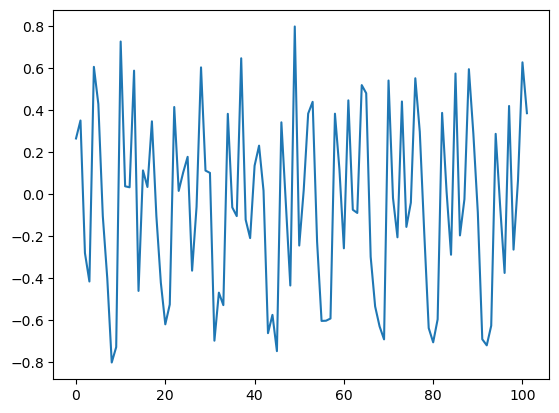

In [6]:
objetivo_train = (-1.6/(np.min(objetivo_train) - np.max(objetivo_train)))*objetivo_train - 0.8 + np.min(objetivo_train)*(1.6/(np.min(objetivo_train) - np.max(objetivo_train)))
plt.plot(objetivo_train)
plt.show()

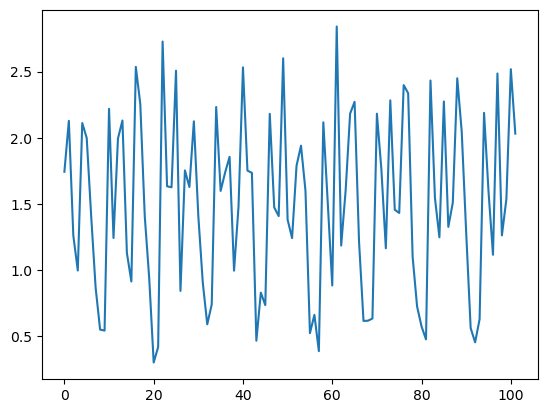

In [7]:
plt.plot(conjunto_train[:,0])
plt.show()

In [8]:
def circuitoRegresor_CodificacionAngular(n_qubits=1):
    qc = QuantumCircuit(n_qubits)
    
    inputs = ParameterVector("inputs",n_qubits)
    pesos = ParameterVector("pesos",15*n_qubits)
    feature_map = QuantumCircuit(n_qubits)
    feature_map.h(range(n_qubits))
    
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
    
    
    ansatz = QuantumCircuit(n_qubits)
    for j in range(5):
        for i in range(n_qubits):
            ansatz.rx(pesos[i + 3*j*n_qubits],i)

        for i in range(n_qubits):
            ansatz.ry(pesos[i + (3*j+1)*n_qubits],i)

        for i in range(n_qubits):
            ansatz.rz(pesos[i + (3*j+2)*n_qubits],i)

        for i in range(n_qubits-1):
            ansatz.cx(i,i+1)
        
    
    
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    
    
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

In [9]:
inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(window)

In [10]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
modeloEstimator = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params
    )

In [12]:
regressor = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error' ,
    optimizer=COBYLA(maxiter=2000),
    callback=callback_graph
)

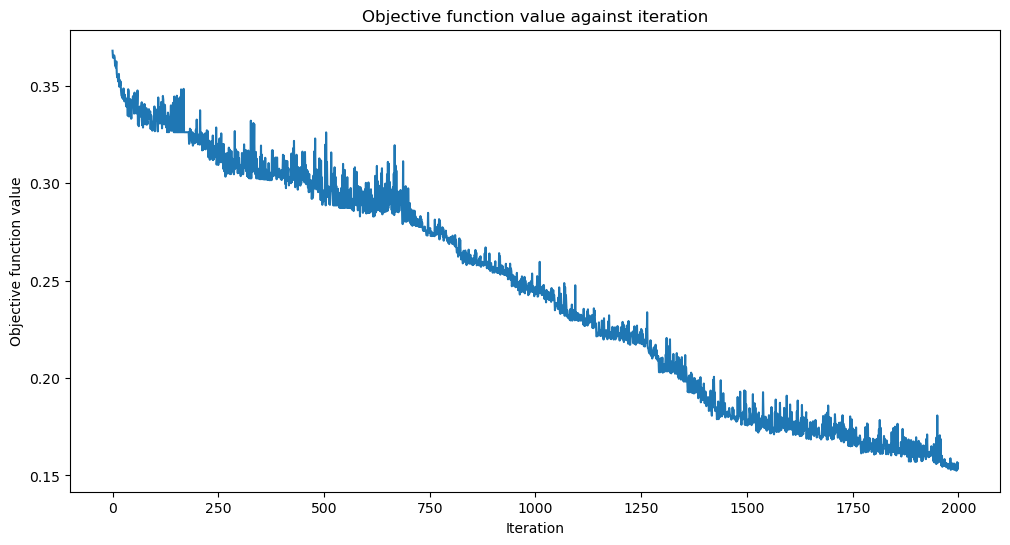

0.7617556747791252

In [13]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(conjunto_train, objetivo_train)
regressor.score(conjunto_train, objetivo_train)

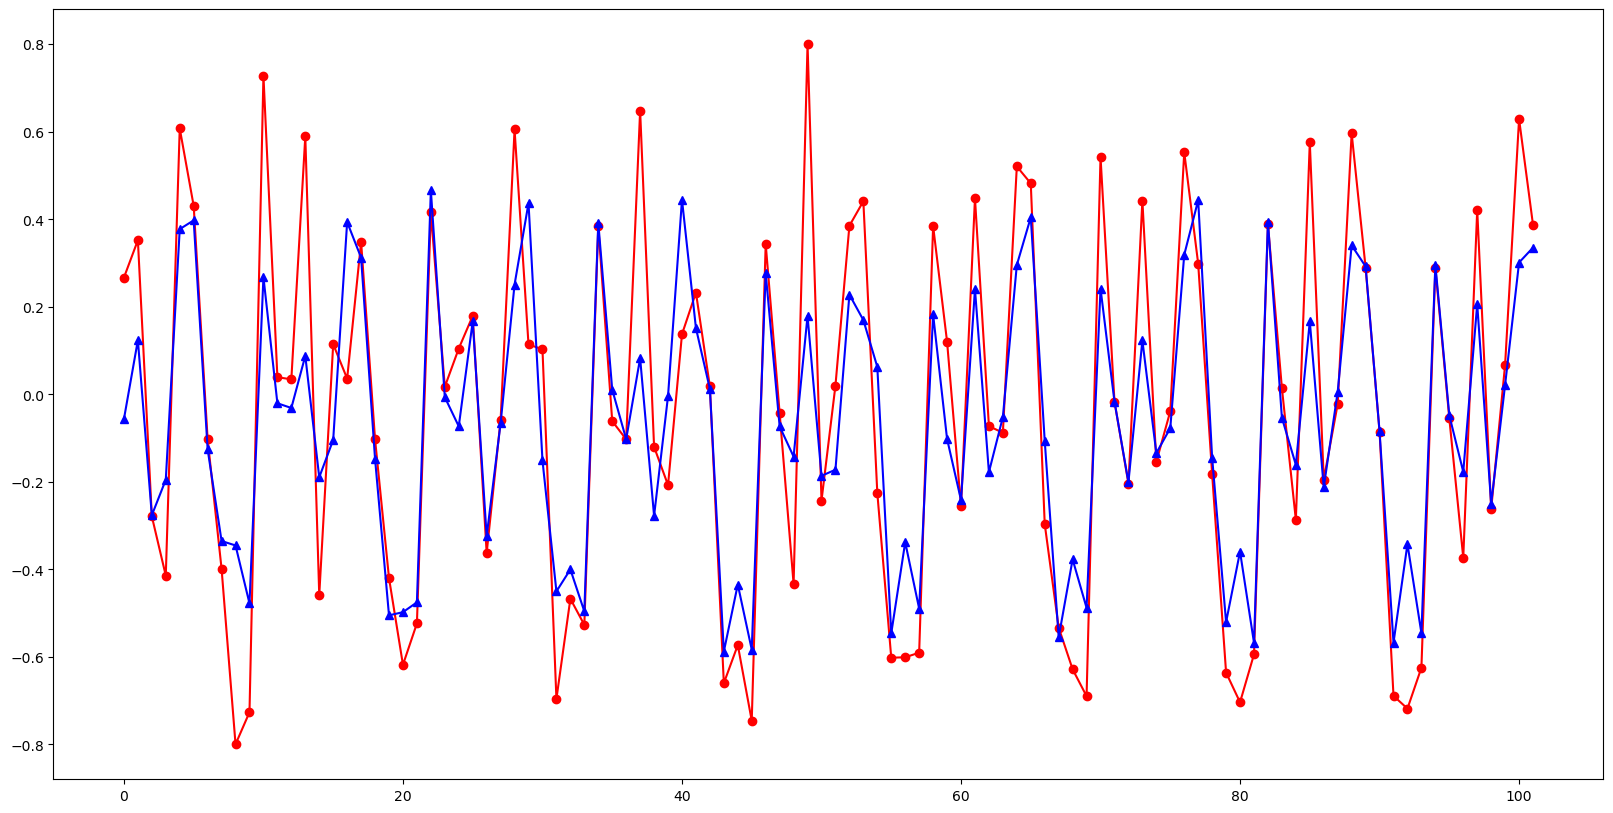

array([ 1.21026361e+00,  9.32314880e-01,  1.01220274e+00,  8.47729908e-01,
       -1.26859427e-01,  1.14934887e+00, -3.35725967e-01,  8.67488799e-01,
        8.88187611e-01,  1.32099600e+00,  2.37698878e+00, -3.05427814e-02,
        1.85683114e+00,  1.58216303e+00,  7.29673156e-01,  1.04578620e+00,
        8.12390718e-01,  5.39338084e-01,  4.08869243e-01,  1.90476609e+00,
        1.46666149e+00,  2.43326529e+00,  1.12939061e+00,  7.10321002e-02,
        1.75769277e+00,  4.94938785e-02,  4.11084725e-01,  1.46692891e+00,
        5.29398691e-01,  7.15843334e-01,  3.45474545e-02,  1.06396294e+00,
        9.14785195e-01,  1.39552793e+00,  4.30528377e-01,  1.38477586e+00,
        3.15363505e-01,  3.88879370e-01,  1.59363497e+00,  5.10420394e-01,
        5.17441976e-01,  5.38859939e-01, -1.58995254e-02,  1.53822831e+00,
        2.40390706e-01,  5.80707254e-01,  1.35440664e+00,  1.26189792e+00,
       -1.09853606e-01, -4.34943649e-03,  2.78513427e-01, -5.54837505e-01,
        3.72013321e-01, -

In [14]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor.weights

In [15]:
np.sum( np.abs(objetivo_train[:] - y_[:]))/(len(objetivo_train))

43.49928060718779

In [16]:
### NO HAY QUE HACER TRANSFORM conjunto_test = scaler.fit_transform(conjunto_test)
conjunto_test = scaler.transform(conjunto_test)

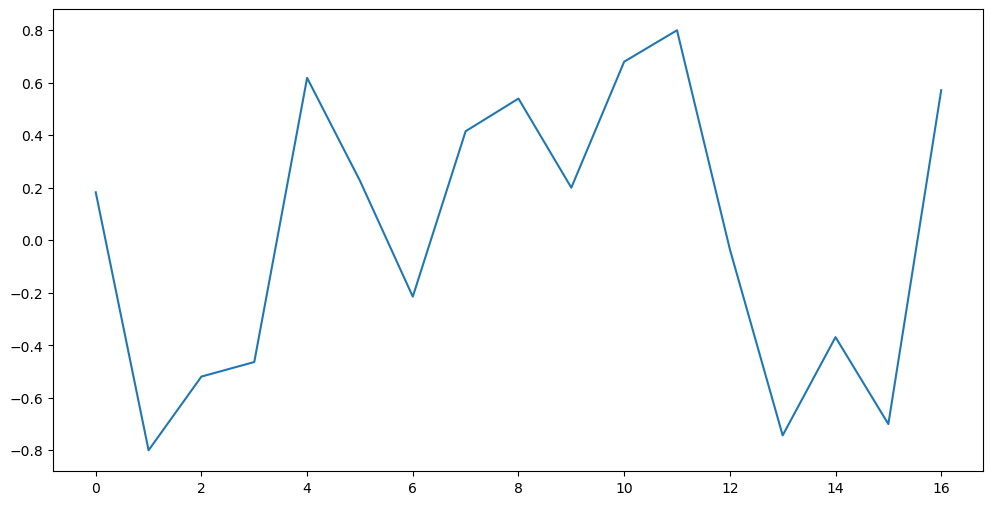

In [17]:
objetivo_test = (-1.6/(np.min(objetivo_test) - np.max(objetivo_test)))*objetivo_test - 0.8 + np.min(objetivo_test)*(1.6/(np.min(objetivo_test) - np.max(objetivo_test)))
plt.plot(objetivo_test)
plt.show()


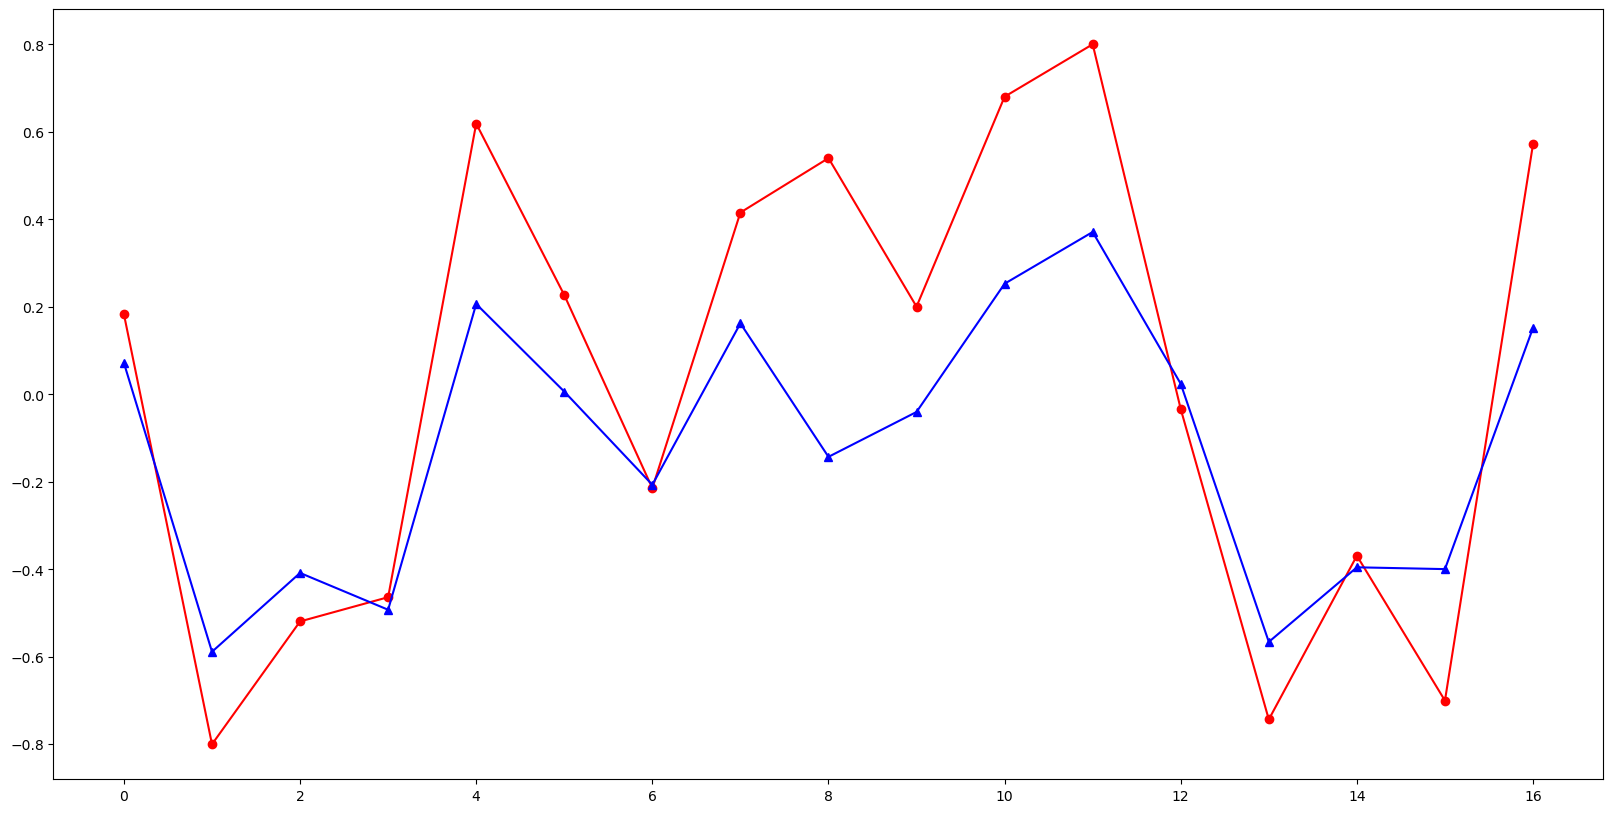

0.6740215737965776

In [18]:
espacio = np.arange(0,objetivo_test.shape[0])
y_ = regressor.predict(conjunto_test)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_test, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor.score(conjunto_test, objetivo_test)

In [19]:
np.sum( (objetivo_test[:] - y_[:])**2)/(len(objetivo_test))

6.600153233639552